In [1]:
import os
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import cv2

#data path 수정
os.chdir("C:\\Users\\Owner2\\Desktop\\G팔로미_vuno")
os.getcwd()

'C:\\Users\\Owner2\\Desktop\\G팔로미_vuno'

In [2]:
X=np.load('data_X.npy')
y=np.load('data_y.npy')

In [3]:
#train, validation set 분리
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.3)

In [4]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    ##featurewise_center=True,
    #featurewise_std_normalization=True, 
    rotation_range=25.0,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True) #수평방향 뒤집기

datagen.fit(X_train)

dgf=datagen.flow(X_train,y_train,batch_size=64)

Using TensorFlow backend.


In [5]:
from keras import layers, models
from keras.applications import VGG16
from keras import Input
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, initializers, regularizers, metrics
from keras.callbacks import ModelCheckpoint
import os
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
 


pre_trained_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
pre_trained_vgg.trainable = True
pre_trained_vgg.summary()

W0608 11:07:17.394017  7728 deprecation_wrapper.py:119] From C:\Users\Owner2\Anaconda3\envs\keras2\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0608 11:07:17.412013  7728 deprecation_wrapper.py:119] From C:\Users\Owner2\Anaconda3\envs\keras2\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0608 11:07:17.417242  7728 deprecation_wrapper.py:119] From C:\Users\Owner2\Anaconda3\envs\keras2\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0608 11:07:17.445009  7728 deprecation_wrapper.py:119] From C:\Users\Owner2\Anaconda3\envs\keras2\lib\site-packages\keras\backend\tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0608 11:07:17.760447  7728

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [6]:
additional_model = models.Sequential()
additional_model.add(pre_trained_vgg)
additional_model.add(layers.Flatten())
additional_model.add(layers.Dense(4096, activation='relu'))
additional_model.add(layers.Dense(2048, activation='relu'))
additional_model.add(layers.Dense(1024, activation='relu'))
additional_model.add(layers.Dense(4, activation='softmax'))

In [7]:
# checkpoint = ModelCheckpoint(filepath='My_VGG_{epoch:03d}_{val_loss:.7f}.hdf5',monitor='loss', mode='min', save_best_only=True)
checkpoint = ModelCheckpoint(filepath='My_VGG_weight_1.hdf5', 
            monitor='loss', 
            mode='min', 
            save_best_only=True)

In [8]:
from keras import backend as K
import tensorflow as tf

def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

def recall(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Negative) = 실제 값이 1(Positive) 전체
    count_true_positive_false_negative = K.sum(y_target_yn)

    # Recall =  (True Positive) / (True Positive + False Negative)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    recall = count_true_positive / (count_true_positive_false_negative + K.epsilon())

    # return a single tensor value
    return recall


def precision(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Positive) = 예측 값이 1(Positive) 전체
    count_true_positive_false_positive = K.sum(y_pred_yn)

    # Precision = (True Positive) / (True Positive + False Positive)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    precision = count_true_positive / (count_true_positive_false_positive + K.epsilon())

    # return a single tensor value
    return precision


def f1score(y_target, y_pred):
    _recall = recall(y_target, y_pred)
    _precision = precision(y_target, y_pred)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    _f1score = ( 2 * _recall * _precision) / (_recall + _precision+ K.epsilon())
    
    # return a single tensor value
    return _f1score

In [9]:
additional_model.compile(loss='categorical_crossentropy',
                         optimizer=optimizers.Adam(lr=2e-5), 
                         metrics=['acc', auc, precision, recall, f1score])

W0608 11:07:19.839517  7728 deprecation_wrapper.py:119] From C:\Users\Owner2\Anaconda3\envs\keras2\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0608 11:07:19.930543  7728 deprecation.py:323] From C:\Users\Owner2\Anaconda3\envs\keras2\lib\site-packages\tensorflow\python\ops\metrics_impl.py:809: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [10]:
X.shape

(2861, 224, 224, 3)

In [11]:
# history1=myvgg.fit(X,y,batch_size=32,
#                   epochs=100,
#                   validation_split=0.3,
#                   callbacks=[checkpoint])

In [12]:
history = additional_model.fit_generator(dgf, 
            steps_per_epoch=150, 
            epochs=100, 
            validation_data=(X_val,y_val), 
            validation_steps=16, 
            callbacks=[checkpoint])

W0608 11:07:38.858042  7728 deprecation.py:323] From C:\Users\Owner2\Anaconda3\envs\keras2\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/100
150/150 [==============================] - 99s 663ms/step - loss: 0.8481 - acc: 0.5534 - auc: 0.7941 - precision: 0.6011 - recall: 0.4526 - f1score: 0.5076 - val_loss: 0.6851 - val_acc: 0.6519 - val_auc: 0.8570 - val_precision: 0.6860 - val_recall: 0.5972 - val_f1score: 0.6381
Epoch 2/100
150/150 [==============================] - 87s 581ms/step - loss: 0.6713 - acc: 0.6313 - auc: 0.8709 - precision: 0.6549 - recall: 0.5895 - f1score: 0.6201 - val_loss: 0.7863 - val_acc: 0.6228 - val_auc: 0.8797 - val_precision: 0.6310 - val_recall: 0.5902 - val_f1score: 0.6098
Epoch 3/100
150/150 [==============================] - 88s 589ms/step - loss: 0.6155 - acc: 0.6790 - auc: 0.8863 - precision: 0.6957 - recall: 0.6487 - f1score: 0.6711 - val_loss: 0.7798 - val_acc: 0.6310 - val_auc: 0.8925 - val_precision: 0.6349 - val_recall: 0.6100 - val_f1score: 0.6221
Epoch 4/100
150/150 [==============================] - 88s 584ms/step - loss: 0.5462 - acc: 0.7134 - auc: 0.8981 - precision: 0.72

150/150 [==============================] - 81s 541ms/step - loss: 0.0317 - acc: 0.9883 - auc: 0.9797 - precision: 0.9885 - recall: 0.9880 - f1score: 0.9883 - val_loss: 2.2778 - val_acc: 0.6391 - val_auc: 0.9799 - val_precision: 0.6396 - val_recall: 0.6380 - val_f1score: 0.6387
Epoch 30/100
150/150 [==============================] - 81s 538ms/step - loss: 0.0483 - acc: 0.9817 - auc: 0.9802 - precision: 0.9819 - recall: 0.9815 - f1score: 0.9817 - val_loss: 2.1577 - val_acc: 0.6275 - val_auc: 0.9804 - val_precision: 0.6292 - val_recall: 0.6263 - val_f1score: 0.6278
Epoch 31/100
150/150 [==============================] - 81s 539ms/step - loss: 0.0312 - acc: 0.9890 - auc: 0.9806 - precision: 0.9892 - recall: 0.9890 - f1score: 0.9891 - val_loss: 2.1344 - val_acc: 0.6496 - val_auc: 0.9808 - val_precision: 0.6503 - val_recall: 0.6496 - val_f1score: 0.6499
Epoch 32/100
150/150 [==============================] - 81s 541ms/step - loss: 0.0463 - acc: 0.9849 - auc: 0.9810 - precision: 0.9851 - reca

150/150 [==============================] - 81s 540ms/step - loss: 0.0200 - acc: 0.9926 - auc: 0.9856 - precision: 0.9927 - recall: 0.9923 - f1score: 0.9925 - val_loss: 2.2294 - val_acc: 0.6414 - val_auc: 0.9856 - val_precision: 0.6432 - val_recall: 0.6403 - val_f1score: 0.6417
Epoch 58/100
150/150 [==============================] - 81s 543ms/step - loss: 0.0233 - acc: 0.9920 - auc: 0.9857 - precision: 0.9923 - recall: 0.9919 - f1score: 0.9921 - val_loss: 2.7042 - val_acc: 0.5949 - val_auc: 0.9857 - val_precision: 0.5943 - val_recall: 0.5914 - val_f1score: 0.5928
Epoch 59/100
150/150 [==============================] - 81s 541ms/step - loss: 0.0553 - acc: 0.9794 - auc: 0.9857 - precision: 0.9794 - recall: 0.9789 - f1score: 0.9792 - val_loss: 2.3176 - val_acc: 0.5960 - val_auc: 0.9857 - val_precision: 0.5969 - val_recall: 0.5949 - val_f1score: 0.5959
Epoch 60/100
150/150 [==============================] - 81s 542ms/step - loss: 0.0166 - acc: 0.9943 - auc: 0.9857 - precision: 0.9943 - reca

150/150 [==============================] - 81s 537ms/step - loss: 0.0141 - acc: 0.9958 - auc: 0.9869 - precision: 0.9958 - recall: 0.9957 - f1score: 0.9958 - val_loss: 2.3104 - val_acc: 0.5984 - val_auc: 0.9869 - val_precision: 0.6009 - val_recall: 0.5972 - val_f1score: 0.5990
Epoch 86/100
150/150 [==============================] - 81s 539ms/step - loss: 0.0225 - acc: 0.9928 - auc: 0.9869 - precision: 0.9929 - recall: 0.9928 - f1score: 0.9928 - val_loss: 2.4096 - val_acc: 0.6263 - val_auc: 0.9869 - val_precision: 0.6258 - val_recall: 0.6251 - val_f1score: 0.6255
Epoch 87/100
150/150 [==============================] - 81s 540ms/step - loss: 0.0121 - acc: 0.9964 - auc: 0.9869 - precision: 0.9964 - recall: 0.9962 - f1score: 0.9963 - val_loss: 2.4744 - val_acc: 0.6345 - val_auc: 0.9869 - val_precision: 0.6345 - val_recall: 0.6345 - val_f1score: 0.6345
Epoch 88/100
150/150 [==============================] - 81s 539ms/step - loss: 0.0032 - acc: 0.9991 - auc: 0.9869 - precision: 0.9991 - reca

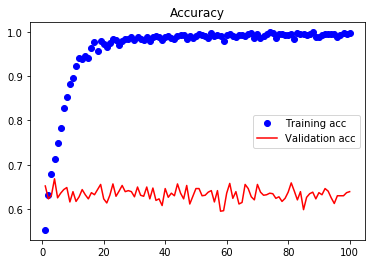

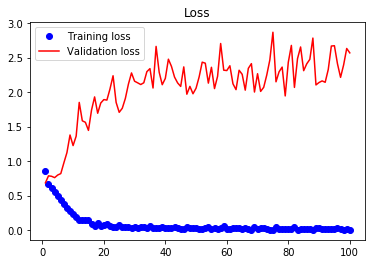

In [13]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(1, len(acc) + 1)
 
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Accuracy')
plt.legend()
plt.figure()
 
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Loss')
plt.legend()
 
plt.show()

In [14]:
X_test=np.load('X_test.npy')
y_test=np.load('y_test.npy')

In [15]:
_loss, _acc, _auc, _precision, _recall, _f1score = additional_model.evaluate(X_test, y_test, batch_size=64)
print('loss: {:.3f}, accuracy: {:.3f}, auc: {:.3f}, precision: {:.3f}, recall: {:.3f}, f1score: {:.3f}'.format(_loss, _acc, _auc, _precision, _recall, _f1score))

704/704 [==============================] - 2s 3ms/step
loss: 12.409, accuracy: 0.230, auc: 0.987, precision: 0.230, recall: 0.230, f1score: 0.230


In [16]:
_loss, _acc, _auc, _precision, _recall, _f1score = additional_model.evaluate(X_val, y_val, batch_size=64)
print('loss: {:.3f}, accuracy: {:.3f}, auc: {:.3f}, precision: {:.3f}, recall: {:.3f}, f1score: {:.3f}'.format(_loss, _acc, _auc, _precision, _recall, _f1score))

859/859 [==============================] - 2s 3ms/step
loss: 2.569, accuracy: 0.639, auc: 0.987, precision: 0.639, recall: 0.637, f1score: 0.638


In [ ]:
myvgg.save('VGG16_Aug_1.h5')